Imports

In [1]:
#############
###paths#####
#############
import sys
import os

from importlib_metadata import distribution
pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############

from numerical.cn_plot import plot1D, surfpattern
from numerical.countPeaksAnalysisFunctions import countPeaks, varPeakDistFunction
from numerical.generalFunctions import round_it
from numerical.fourierAnalysisFunctions import psEntropyFunction, plotFourier


from analytical.linear_stability_analysis import detailed_turing_analysis_dict
from randomfunctions import plot_all_dispersion, plot_highest_dispersion

from scipy.signal import find_peaks
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



System definitions

In [2]:
circuit_n='turinghill'
variant= 0
n_species=2
mechanism='nogrowth'
L=50; x_gridpoints=5; J=L*x_gridpoints;I=J 
T=5000; t_gridpoints = 30; N=T*t_gridpoints #Number of timepoints
filename= lambda parID: '%s_variant%s_%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,mechanism,parID,L,J,T,N)
n_param_sets=2000000
# lsa_df= pickle.load( open(modellingpath + '/growth/out/analytical/lsa_dataframes/lsa_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# single_lsa_df =  lsa_df.xs(0, level=1)
# parID_list = pickle.load(open( modellingpath + '/growth/out/numerical/%s/%s/data/parID_list_%s.pkl'%(circuit_n,mechanism,filename('x')), "rb" ) )
# parID_list = [int(parID) for parID in parID_list]
# instability_df= pickle.load( open(modellingpath + '/growth/out/analytical/instability/instability_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# singleSsInstability_df = instability_df.loc[instability_df['ss_n']==1]
# singleSsInstability_df
pattern_df = pickle.load(open( modellingpath + '/growth/out/patternAnalysis/%s/%s/pattern/pattern_df_%s.pkl'%(circuit_n,mechanism,filename('x')), 'rb'))


Functions

In [3]:
def parID_display(parID, L,J,T,round=False,crop=100,ss_n=0,df = pattern_df):
    #data
    U = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
    #plot
    plot1D(U,round=round)

    plt.subplots(figsize=(10,4))

    #dispersion
    plt.subplot(121)
    parID_dispersion(parID,crop,ss_n)
    #convergence
    plt.subplot(122)

    parID_surfpattern(parID,L,J,T)
    plt.tight_layout()
    plt.show()
def parID_surfpattern(parID,L,J,T,record_every_x_hours = 10):
    #data 
    U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
    
    #grids
    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    reduced_t_grid = np.arange(0,T,record_every_x_hours) 

    #plot
    surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=1, rate=0, savefig=False,filename='',logResults=False,normalize=False)


def parID_dispersion(parID,crop, ss_n, df = pattern_df):
    #dispersion
    par_dict = df.loc[parID].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    out = detailed_turing_analysis_dict(par_dict, circuit_n, n_species)
    # plot_all_dispersion(out[-3][ss_n],2, crop=crop)
    plot_highest_dispersion(out[-3][ss_n],crop=crop)


Value counts and df definitions

In [6]:
print('\n',pattern_df['system_class'].value_counts())


 simple stable           1908054
simple unstable           37516
hopf                      36232
complex unstable          17569
turing I hopf               616
no steady state              10
turing I oscillatory          3
Name: system_class, dtype: int64


## Turing I Hopf

In [25]:
df1 = pattern_df.loc[(pattern_df['system_class']=='turing I hopf') &  (pattern_df['pattern']=='Non-Stationary heterogeneity')]
print(pattern_df.loc[pattern_df['system_class']=='turing I hopf']['pattern'].value_counts())


Temporal Oscillator             569
Homogeneous                      30
Non-Stationary heterogeneity     11
Stationary periodic wave          6
Name: pattern, dtype: int64


192571


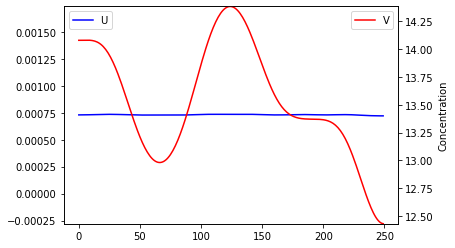

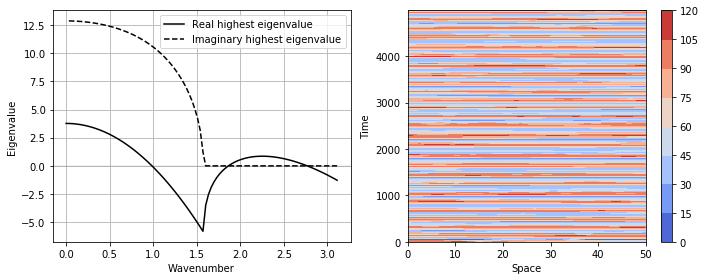

flat: False, converged: False


669362


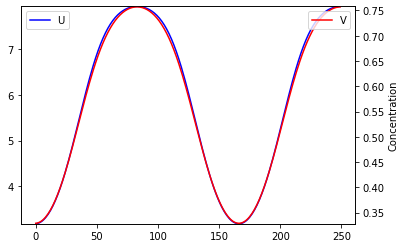

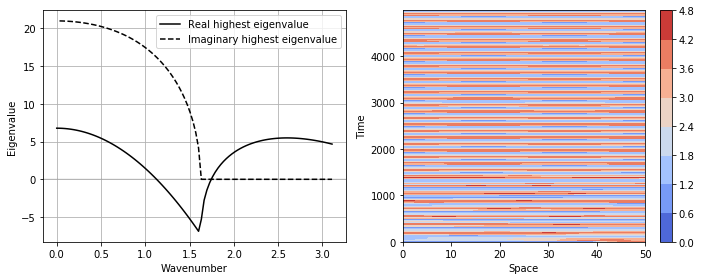

flat: False, converged: False


950793


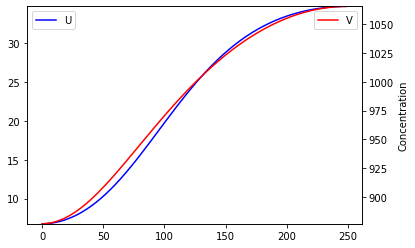

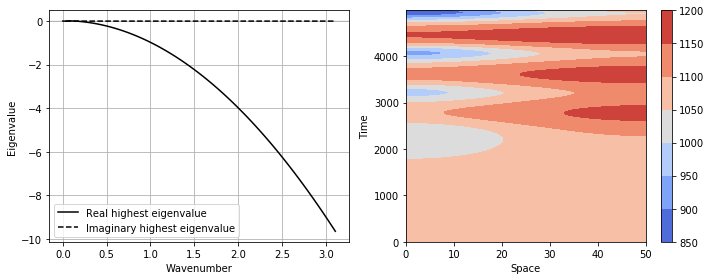

flat: False, converged: False


986009


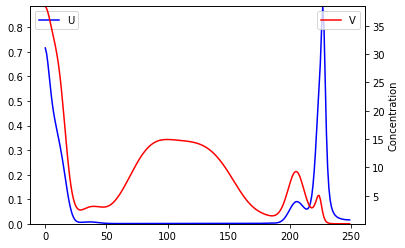

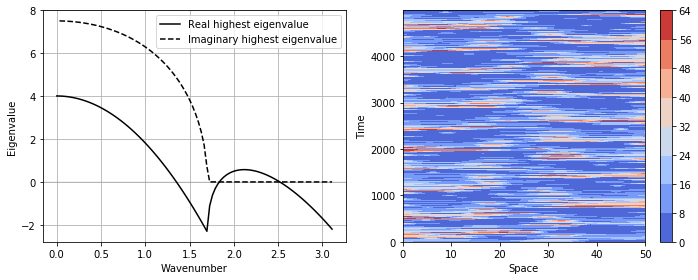

flat: False, converged: False


1338269


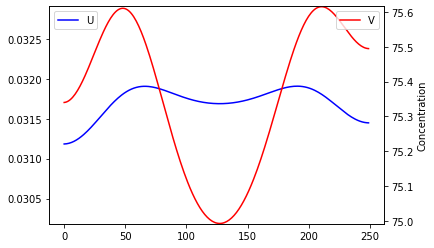

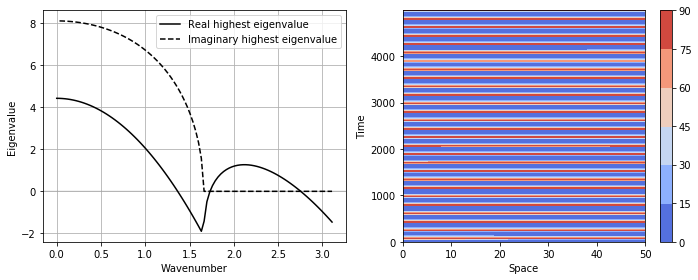

flat: False, converged: False


1499747


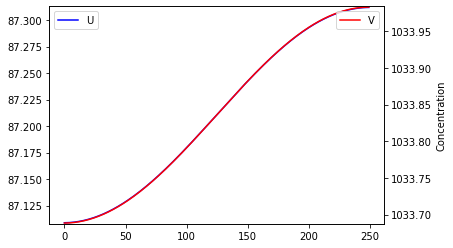

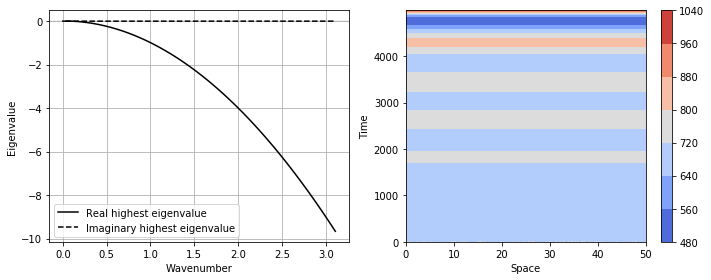

flat: False, converged: False


1616819


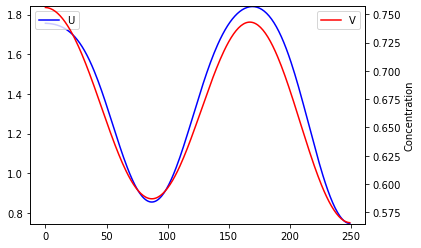

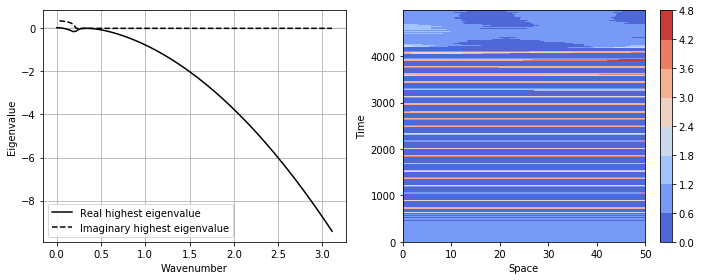

flat: False, converged: False


1711247


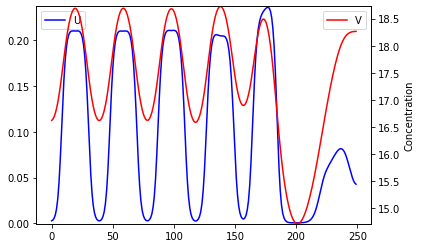

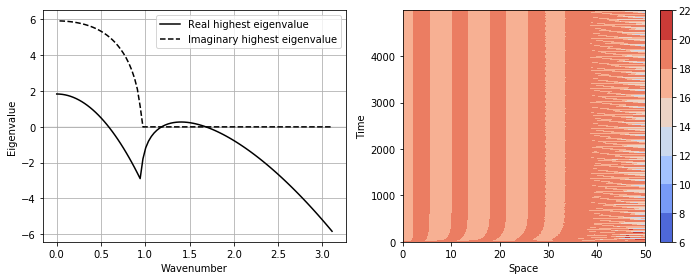

flat: False, converged: False


1878903


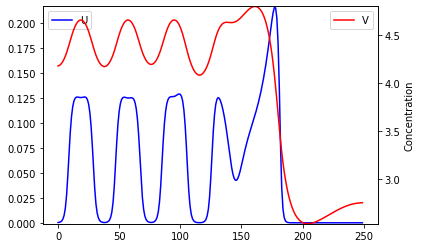

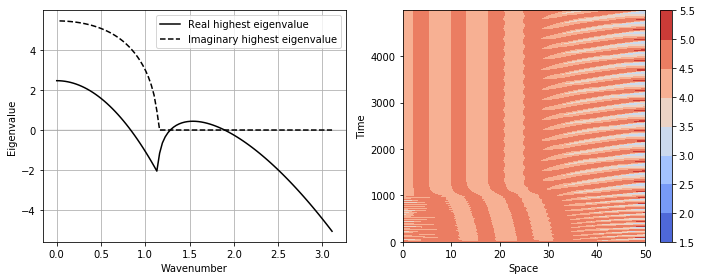

flat: False, converged: False




In [26]:
for parID in df1.index:
    if pattern_df.loc[parID]['ss_n']==1:
        print(parID)
        # print(pattern_df.loc[parID])
        # print(pattern_df.loc[parID]['ss_n'])
        #load records 
        U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
        U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


        parID_display(parID,L,J,T, crop=100)

        #check if flat with diff function
        diffUfinal = np.round(np.diff(U_final),decimals=3)
        if np.all(diffUfinal==0)==True:
            flat=True
        else:
            flat=False

        #check if convergence with diff function
        diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=6)
        
        if np.all(diffUrecord==0) ==True:
            converged=True
        else:
            converged=False
        time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
        # autocorr(np.array(time_vector))
        print(f'flat: {flat}, converged: {converged}')
        print('\n')


## Hopf 

In [8]:
df1 = pattern_df.loc[(pattern_df['system_class']=='hopf') &  (pattern_df['pattern']=='Non-Stationary heterogeneity')]
print(pattern_df.loc[pattern_df['system_class']=='hopf']['pattern'].value_counts())


Temporal Oscillator             25371
Non-Stationary heterogeneity     9060
Homogeneous                      1800
Stationary periodic wave            1
Name: pattern, dtype: int64


129


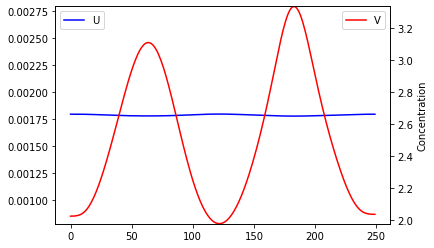

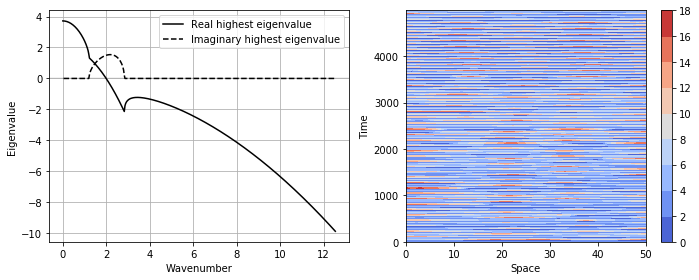

flat: False, converged: False


221


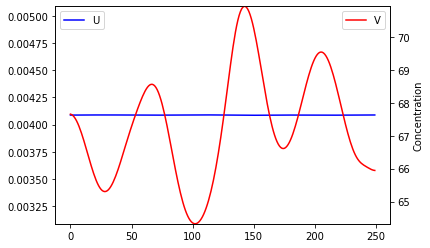

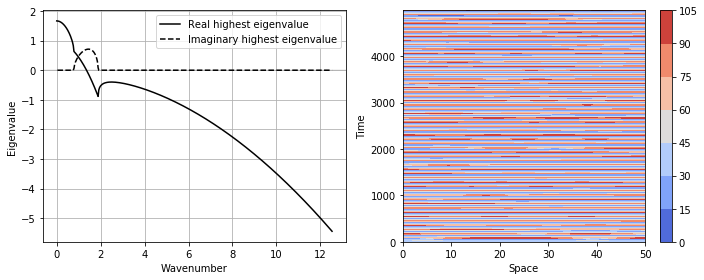

flat: False, converged: False


1753


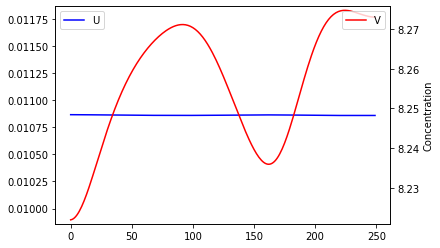

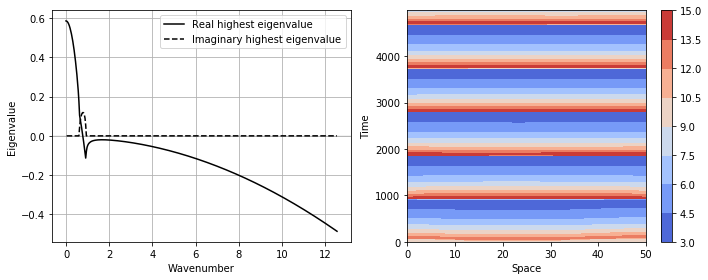

flat: False, converged: False


2445


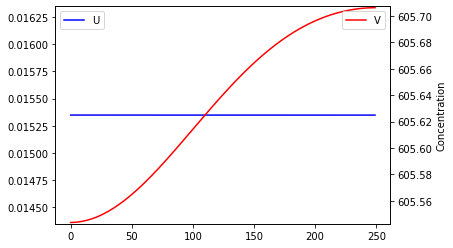

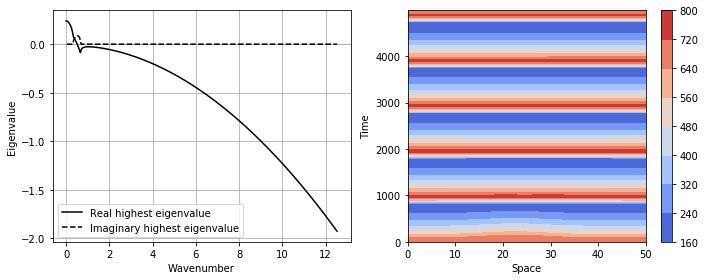

flat: False, converged: False


2529


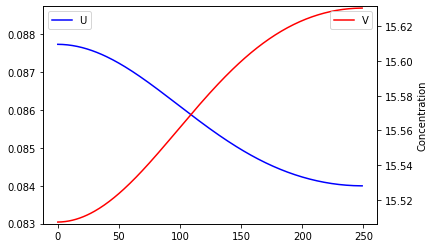

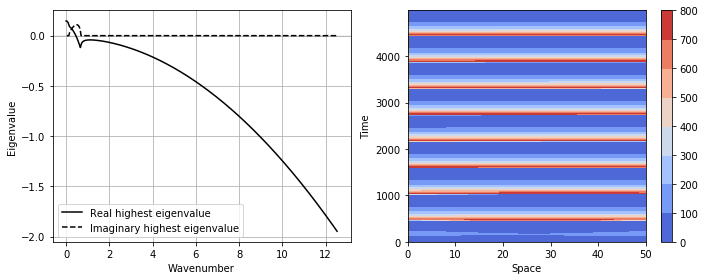

flat: False, converged: False


2806


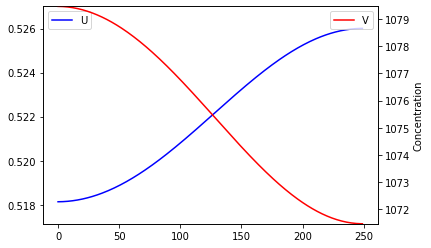

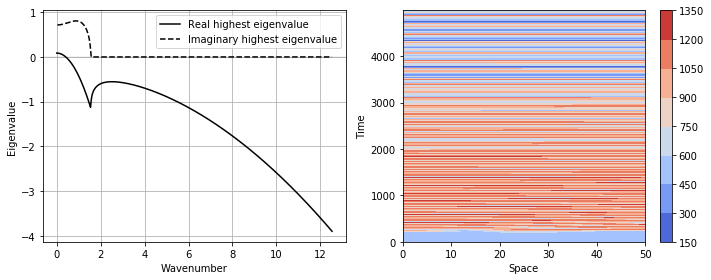

flat: False, converged: False


3217


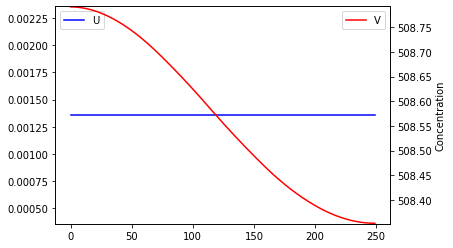

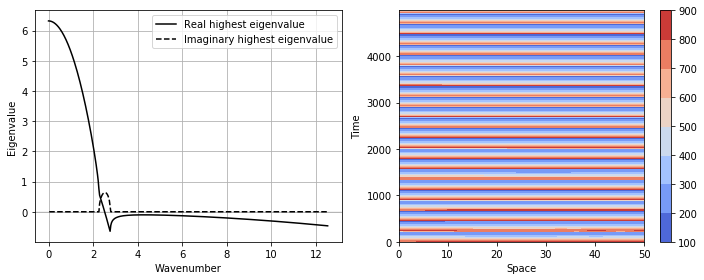

flat: False, converged: False


3276


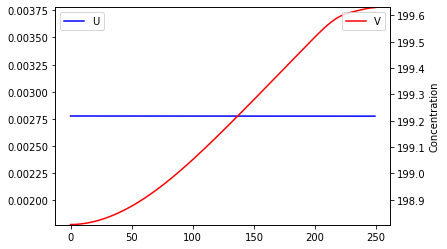

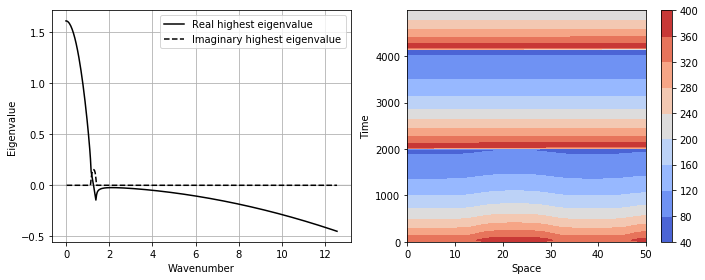

flat: False, converged: False


3442


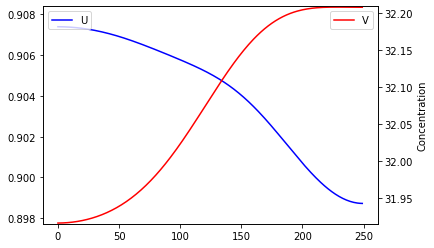

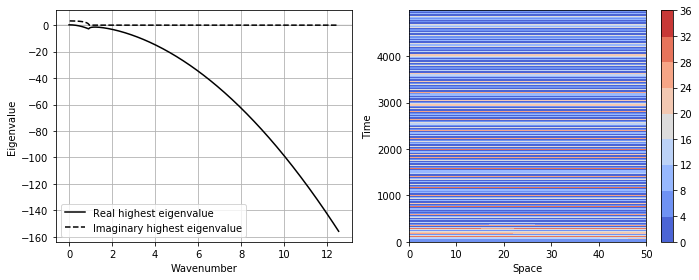

flat: False, converged: False


3838


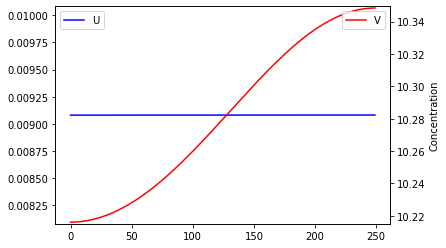

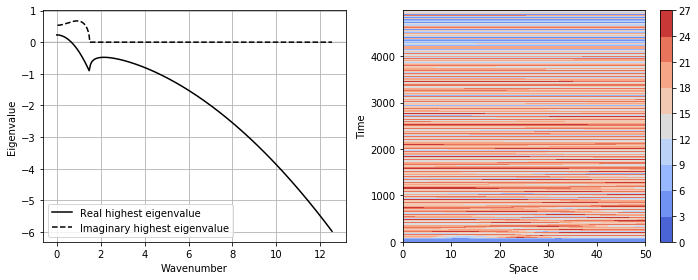

flat: False, converged: False


4073


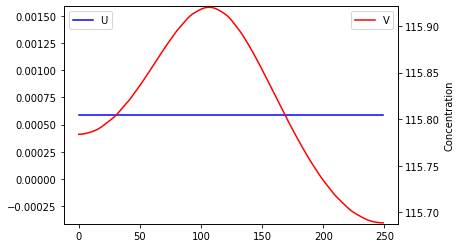

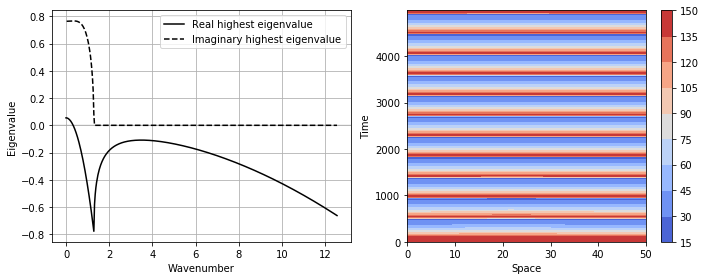

flat: False, converged: False


4162


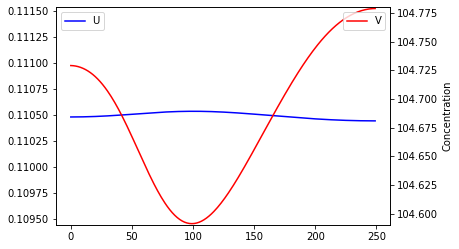

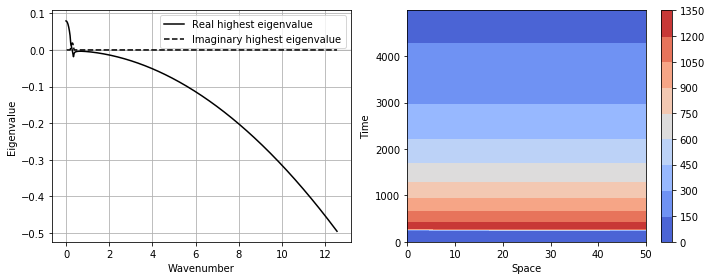

flat: False, converged: False


4228


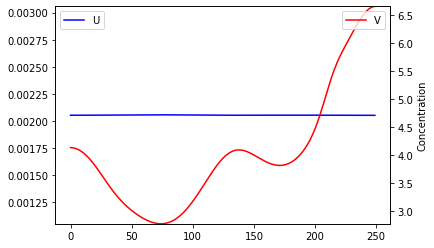

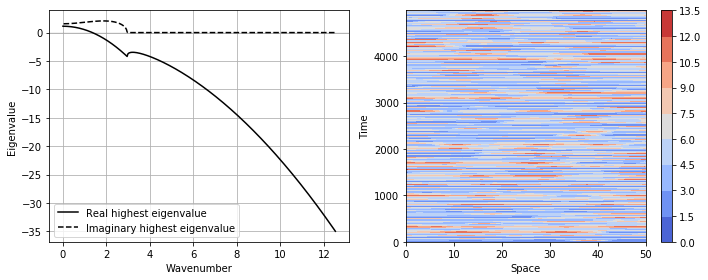

flat: False, converged: False


4575


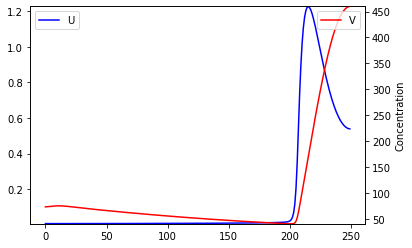

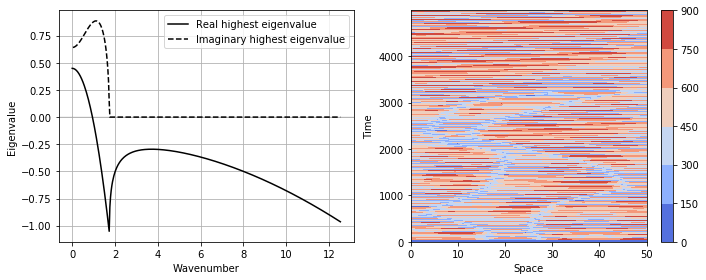

flat: False, converged: False


4789


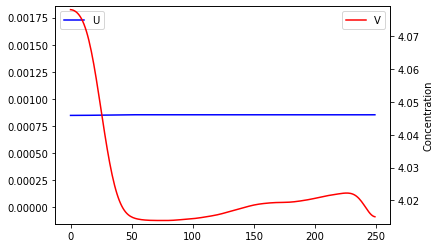

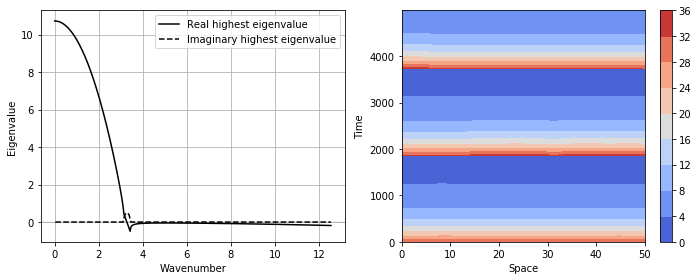

flat: False, converged: False


4816


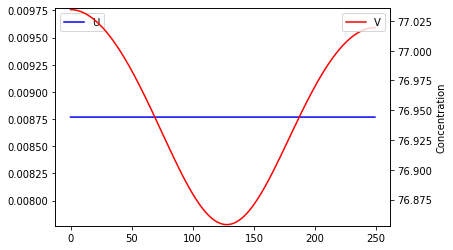

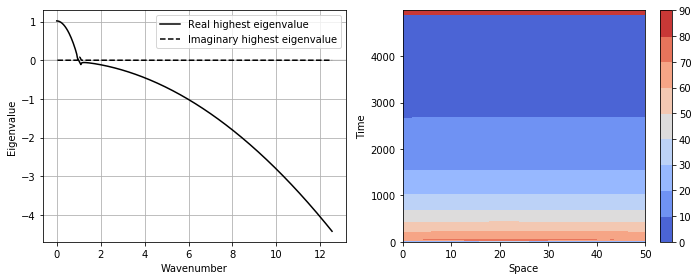

flat: False, converged: False


5058


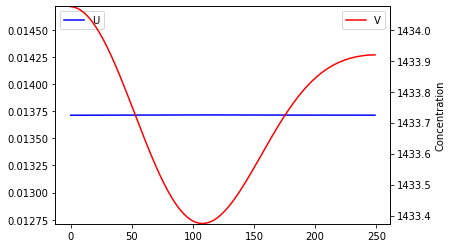

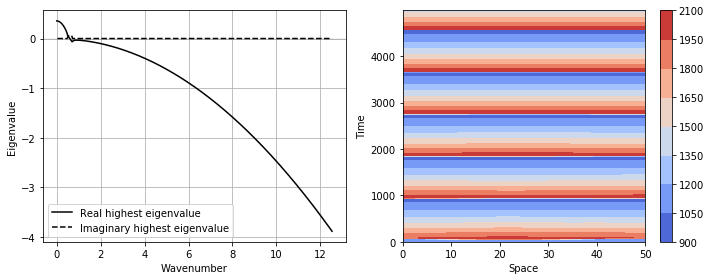

flat: False, converged: False


5213


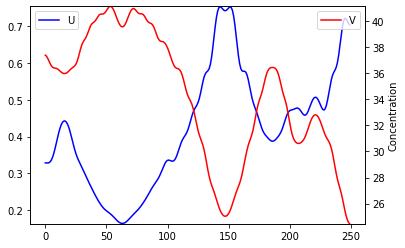

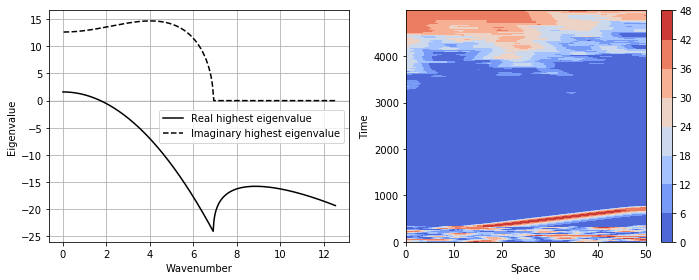

flat: False, converged: False


5387


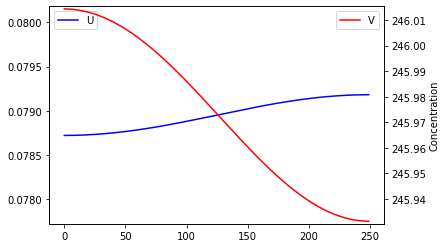

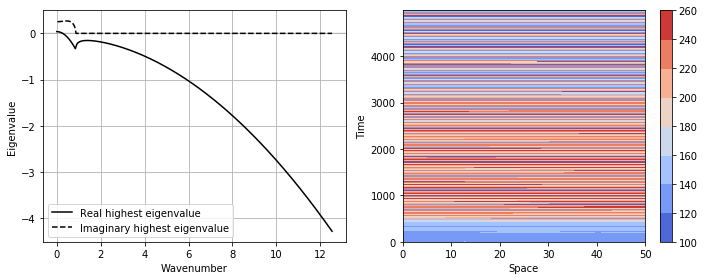

flat: False, converged: False


5577


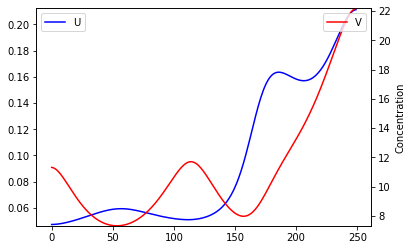

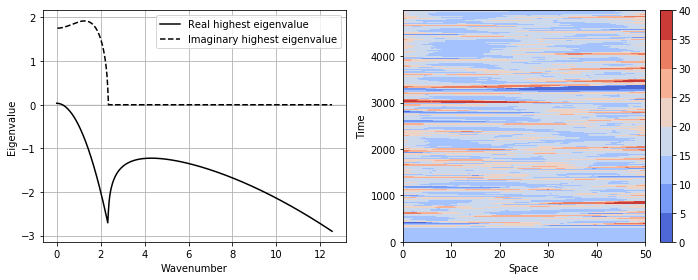

flat: False, converged: False


5877


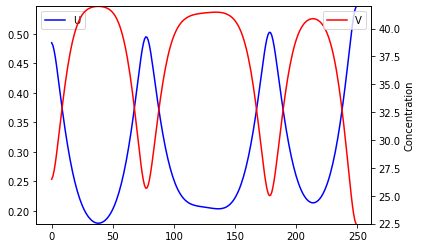

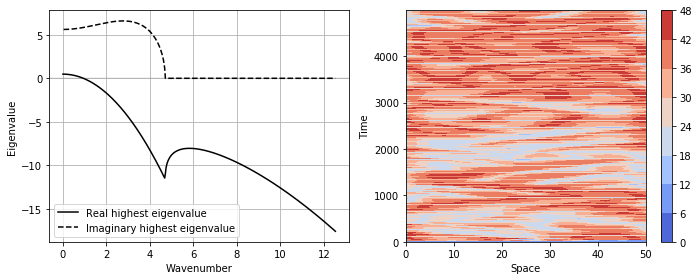

flat: False, converged: False


5976


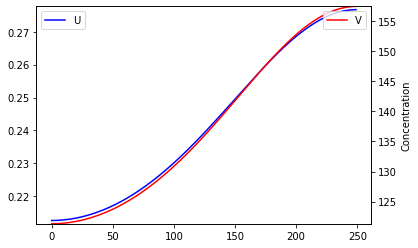

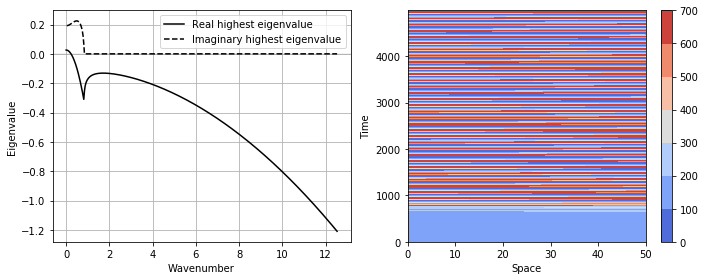

flat: False, converged: False


6292


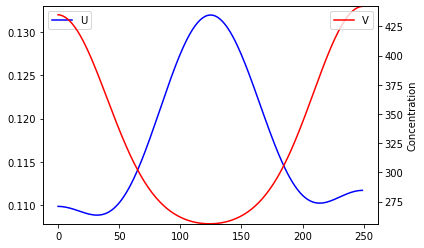

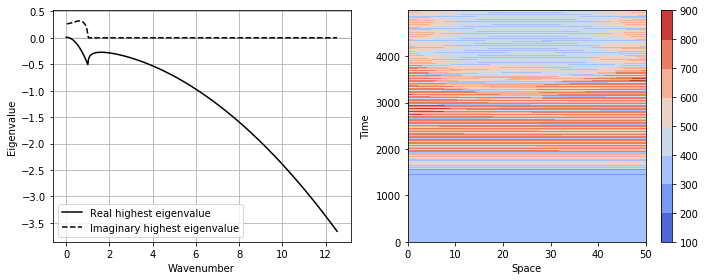

flat: False, converged: False


6762


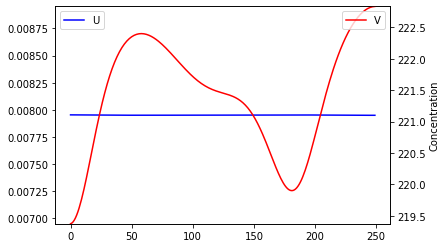

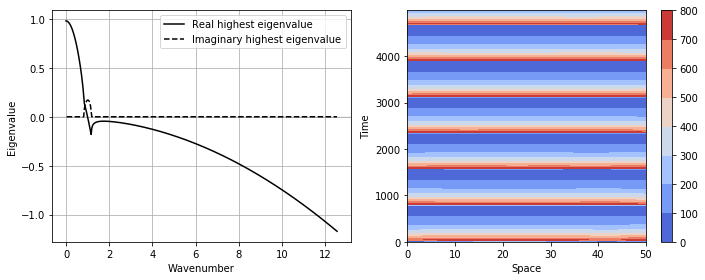

flat: False, converged: False


7051


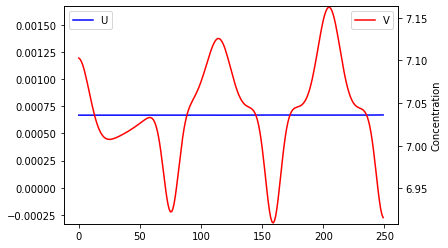

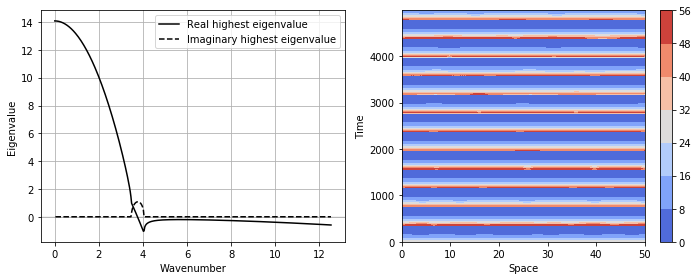

flat: False, converged: False


7186


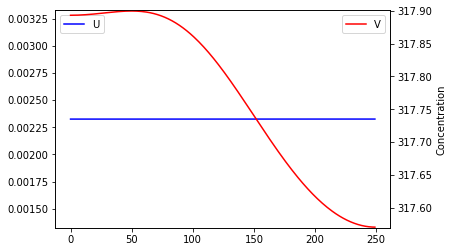

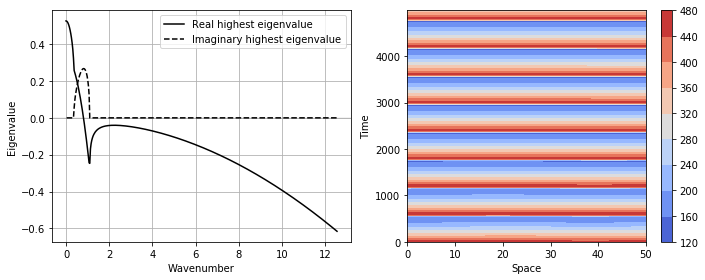

flat: False, converged: False


7304


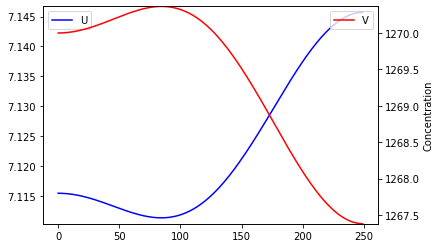

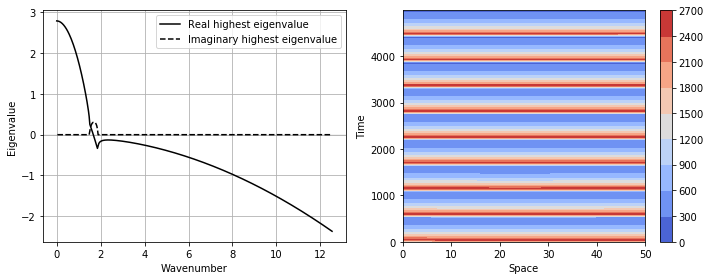

flat: False, converged: False


7322


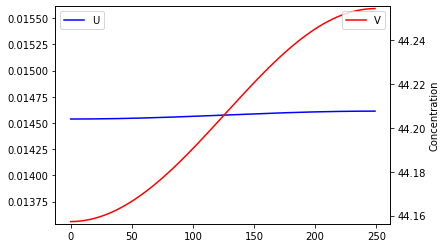

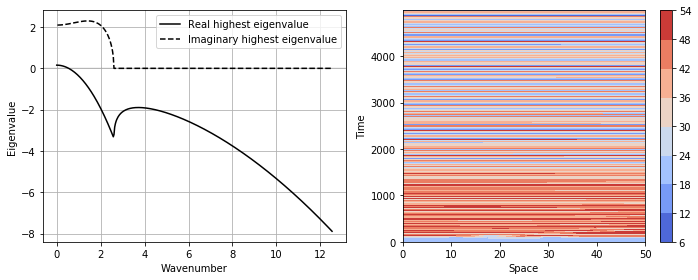

flat: False, converged: False


7632


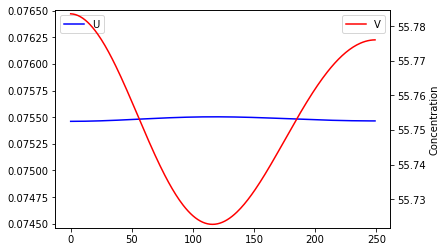

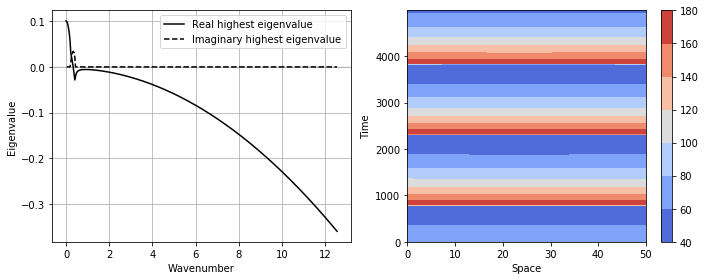

flat: False, converged: False


7952


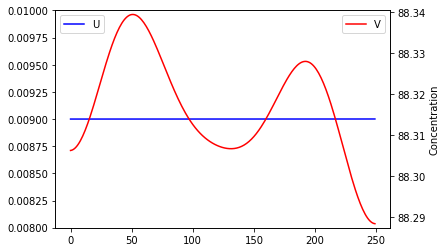

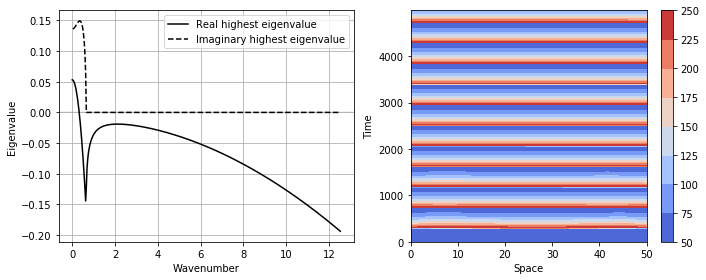

flat: False, converged: False




In [5]:
for parID in df1.index[:30]:
    if pattern_df.loc[parID]['ss_n']==1:
        print(parID)
        # print(pattern_df.loc[parID])
        # print(pattern_df.loc[parID]['ss_n'])
        #load records 
        U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
        U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


        parID_display(parID,L,J,T, crop=400)

        #check if flat with diff function
        diffUfinal = np.round(np.diff(U_final),decimals=3)
        if np.all(diffUfinal==0)==True:
            flat=True
        else:
            flat=False

        #check if convergence with diff function
        diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=6)
        
        if np.all(diffUrecord==0) ==True:
            converged=True
        else:
            converged=False
        time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
        # autocorr(np.array(time_vector))
        print(f'flat: {flat}, converged: {converged}')
        print('\n')


In [ ]:

for parID in parID_list[20:30]:
    print(parID)
    #load records 
    U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
    U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


    # parID_display(parID,L,J,T, crop=100)

    #check if flat with diff function
    diffUfinal = np.round(np.diff(U_final),decimals=3)
    if np.all(diffUfinal==0)==True:
        flat=True
    else:
        flat=False

    #check if convergence with diff function
    diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=3)
    if np.all(diffUrecord==0) ==True:
        converged=True
    else:
        converged=False


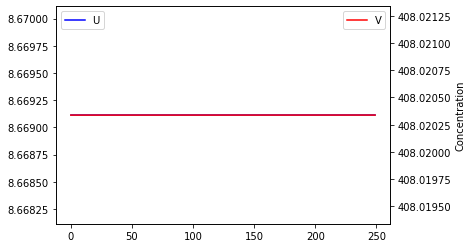

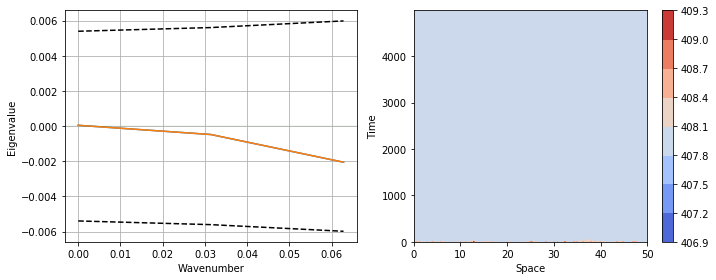

In [28]:
parID_display(8648,L,J,T, crop=3)

In [7]:
def autocorr(x):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr).argmax() + 1
    r = acorr[lag-1]        
    if np.abs(r) > 0.5:
      print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
    else: 
      print('Appears to be not autocorrelated')
    return r, lag

Appears to be autocorrelated with r = 0.8000327043224239, lag = 197


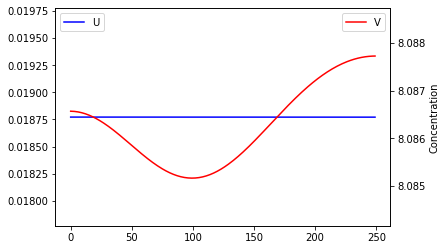

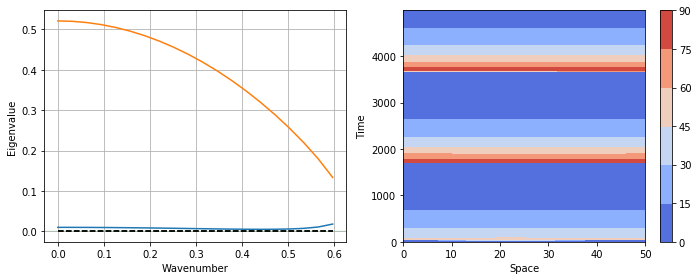

In [12]:
parID=2932
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
autocorr(np.array(time_vector))
parID_display(parID,L,J,T, crop=20)


Appears to be autocorrelated with r = 0.9899645707686601, lag = 1


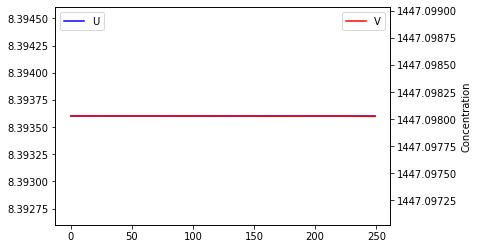

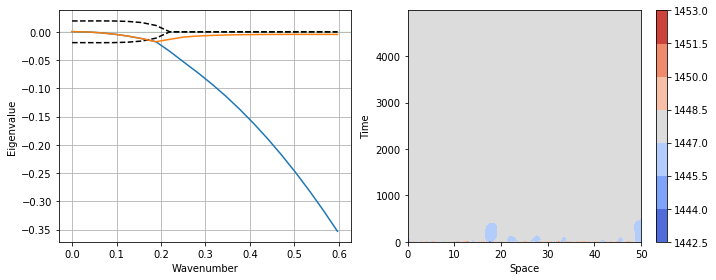

In [22]:
parID=2886
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
autocorr(np.array(time_vector))
parID_display(parID,L,J,T, crop=20)


Appears to be autocorrelated with r = 0.9285649749467298, lag = 1


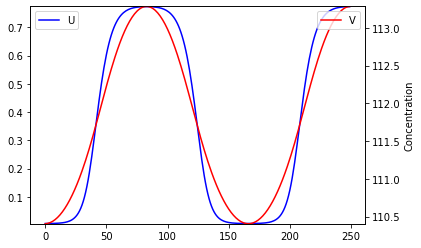

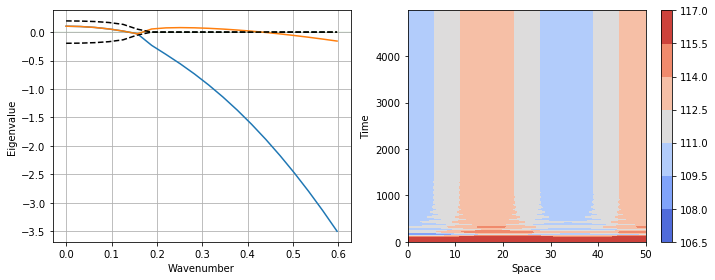

In [23]:
parID=193560
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
autocorr(np.array(time_vector))
parID_display(parID,L,J,T, crop=20)


12019
1.0


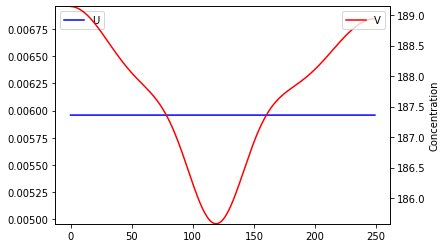

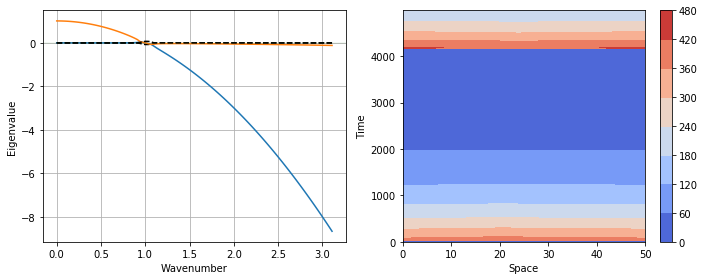

[[-3.031326 -3.031263 -3.031135 ... -3.021888 -3.021939 -3.021964]
 [-3.00096  -3.000896 -3.00077  ... -2.991721 -2.991773 -2.991798]
 [-2.970897 -2.970834 -2.970709 ... -2.961855 -2.961907 -2.961932]
 ...
 [-1.908225 -1.908196 -1.908138 ... -1.9046   -1.904635 -1.904652]
 [-1.88914  -1.889112 -1.889055 ... -1.885585 -1.885619 -1.885636]
 [-1.870247 -1.870219 -1.870163 ... -1.86676  -1.866794 -1.866811]]
Appears to be not autocorrelated
flat: False, converged: False




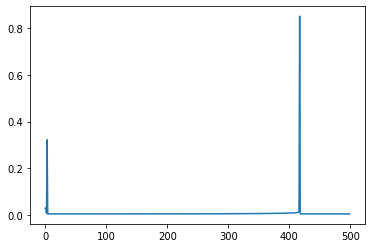

In [44]:
parID=12019
print(parID)
print(pattern_df.loc[parID]['ss_n'])
#load records 
U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


parID_display(parID,L,J,T, crop=100)

#check if flat with diff function
diffUfinal = np.round(np.diff(U_final),decimals=3)
if np.all(diffUfinal==0)==True:
    flat=True
else:
    flat=False

#check if convergence with diff function
diffUrecord = np.round(np.diff(U_record[1][-50:], axis=0),decimals=6)
print(diffUrecord)
if np.all(diffUrecord==0) ==True:
    converged=True
else:
    converged=False
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
plt.plot(time_vector)
autocorr(np.array(time_vector))
print(f'flat: {flat}, converged: {converged}')
print('\n')